
=== Distribución de predicciones: RESNET18 ===
      class  count
0       BCC    396
1     SCCKA    284
2       BKL    124
3        NV     99
4       MEL     42
5      VASC     10
6        DF      2
7     AKIEC      1
8   BEN_OTH      0
9       INF      0
10  MAL_OTH      0


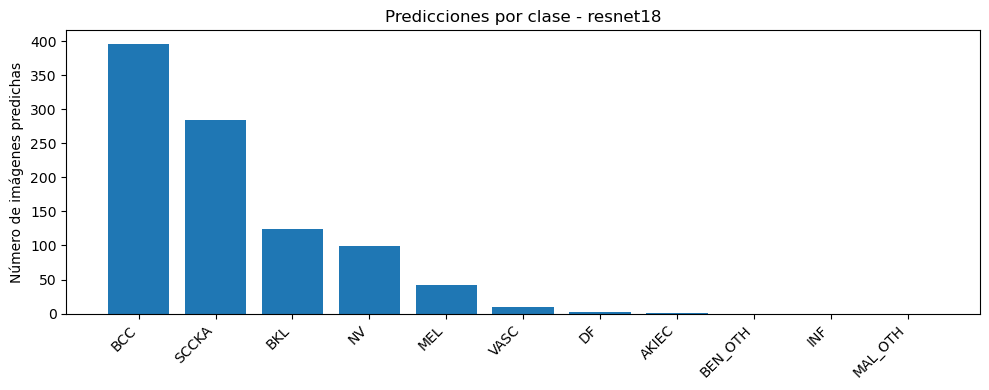


=== Distribución de predicciones: MOBILENETV3_SMALL ===
      class  count
0       BCC    372
1     SCCKA    185
2       BKL    125
3        NV    109
4     AKIEC     88
5       MEL     49
6      VASC     16
7        DF     12
8   BEN_OTH      1
9   MAL_OTH      1
10      INF      0


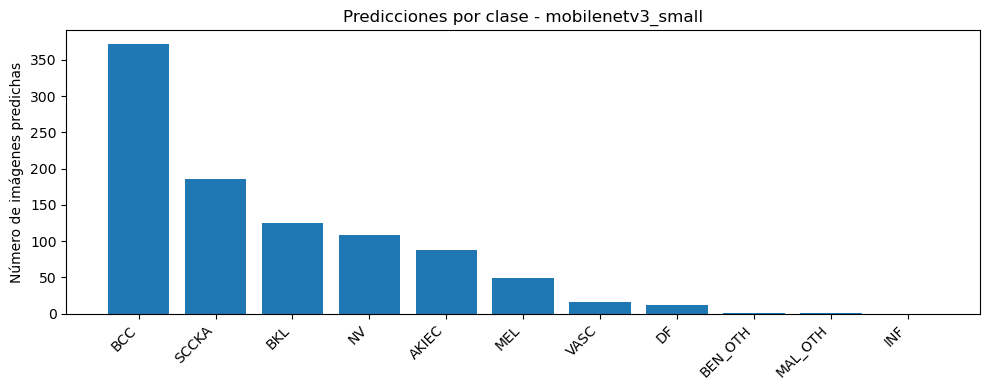


=== Distribución de predicciones: EFFICIENTNET_B0 ===
      class  count
0       BCC    329
1     SCCKA    206
2        NV    122
3       BKL    120
4     AKIEC     79
5       MEL     66
6        DF     13
7      VASC     13
8       INF     10
9   BEN_OTH      0
10  MAL_OTH      0


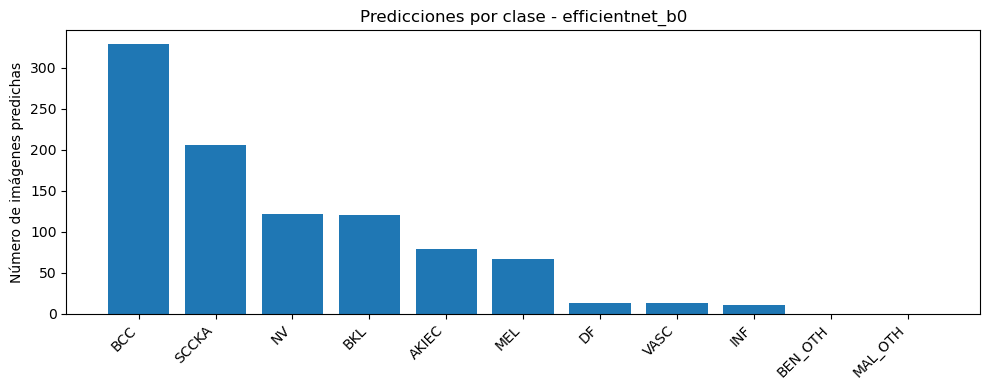

In [7]:
# =========================
# Notebook: Predicción y análisis de distribución de clases en TEST sin etiquetas
# =========================

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image, ImageFile
from pathlib import Path
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

# ---------- Configuración ----------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

MODEL_PATHS = {
    "resnet18": "/Users/kevinjiro/Desktop/data Piel/Model/best_resnet18.pth",
    "mobilenetv3_small": "/Users/kevinjiro/Desktop/data Piel/Model/best_mobilenetv3_small.pth",
    "efficientnet_b0": "/Users/kevinjiro/Desktop/data Piel/Model/best_efficientnet_b0.pth",
}

TEST_DIR = Path("/Users/kevinjiro/Desktop/data Piel/test/MILK10k_Test_Input")

# Ajusta las clases según tu entrenamiento
class_cols = ['AKIEC','BCC','BEN_OTH','BKL','DF','INF','MAL_OTH','MEL','NV','SCCKA','VASC']
num_classes = len(class_cols)

ImageFile.LOAD_TRUNCATED_IMAGES = True

# =========================
# 1) Dataset de Test sin etiquetas
# =========================
class TestDataset(Dataset):
    def __init__(self, root, transforms):
        self.paths = list(Path(root).rglob("*.jpg"))
        self.transforms = transforms
    def __len__(self):
        return len(self.paths)
    def __getitem__(self, idx):
        img_path = self.paths[idx]
        x = Image.open(img_path).convert("RGB")
        x = self.transforms(x)
        return x, str(img_path)

img_size = 224
test_tfms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

test_ds = TestDataset(TEST_DIR, test_tfms)
test_dl = DataLoader(test_ds, batch_size=64, shuffle=False, num_workers=0)

# =========================
# 2) Función para crear el modelo y cargar pesos
# =========================
def build_model(model_name: str, num_classes: int, device=DEVICE):
    name = model_name.lower()
    if name == "resnet18":
        model = models.resnet18(weights=None)
        in_feats = model.fc.in_features
        model.fc = nn.Linear(in_feats, num_classes)
    elif name == "mobilenetv3_small":
        model = models.mobilenet_v3_small(weights=None)
        in_feats = model.classifier[-1].in_features
        model.classifier[-1] = nn.Linear(in_feats, num_classes)
    elif name == "efficientnet_b0":
        model = models.efficientnet_b0(weights=None)
        in_feats = model.classifier[-1].in_features
        model.classifier[-1] = nn.Linear(in_feats, num_classes)
    else:
        raise ValueError(f"Modelo no soportado: {model_name}")
    return model.to(device)

def load_checkpoint(checkpoint_path: str, model_name: str):
    model = build_model(model_name, num_classes, device=DEVICE)
    state = torch.load(checkpoint_path, map_location=DEVICE)
    model.load_state_dict(state["model"])
    model.eval()
    return model

# =========================
# 3) Predicción y conteo por clase
# =========================
def predict_distribution(model_name, checkpoint_path):
    model = load_checkpoint(checkpoint_path, model_name)
    counts = Counter()

    with torch.no_grad():
        for xb, paths in test_dl:
            xb = xb.to(DEVICE)
            logits = model(xb)
            preds = logits.argmax(dim=1).cpu().numpy()
            counts.update(preds)

    # Convertir a DataFrame ordenado
    counts_df = pd.DataFrame({
        "class": class_cols,
        "count": [counts[i] for i in range(len(class_cols))]
    }).sort_values("count", ascending=False).reset_index(drop=True)

    return counts_df

# =========================
# 4) Ejecutar para los tres modelos y graficar
# =========================
distributions = {}
for name, path in MODEL_PATHS.items():
    print(f"\n=== Distribución de predicciones: {name.upper()} ===")
    dist_df = predict_distribution(name, path)
    distributions[name] = dist_df
    print(dist_df)

    # Histograma simple
    plt.figure(figsize=(10,4))
    plt.bar(dist_df["class"], dist_df["count"])
    plt.title(f"Predicciones por clase - {name}")
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Número de imágenes predichas")
    plt.tight_layout()
    plt.show()
